Original models from:
https://www.kaggle.com/mayu0116/hyper-parameters-tuning-of-dtree-rf-svm-knn

In [1]:
#importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

#import classifier modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


In [2]:
#definitions that create and train the models

def train_DecisionTree(train_X, train_y):
    model= DecisionTreeClassifier(random_state=1234)
    
    #Hyper Parameters Set
    params = {'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
              'random_state':[123]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    #Learning
    model1.fit(train_X,train_y)
    
    return model1


def train_RandomForest(train_X, train_y):
    model=RandomForestClassifier()
    
    #hyper parameters set
    params = {'criterion':['gini','entropy'],
              'n_estimators':[10,15,20,25,30],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[3,4,5,6,7], 
              'random_state':[123],
              'n_jobs':[-1]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    #learning
    model1.fit(train_X,train_y)
    
    return model1


def train_SVM(train_X, train_y):
    model=svm.SVC()
    
    #Hyper Parameters Set
    params = {'C': [6,7,8,9,10,11,12], 
              'kernel': ['linear','rbf'],
              'probability': [True]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    #Learning
    model1.fit(train_X,train_y)
    
    return model1


def train_KNeighborsClassifier(train_X, train_y):
    model = KNeighborsClassifier(n_jobs=-1)
    
    #Hyper Parameters Set
    params = {'n_neighbors':[5,6,7,8,9,10],
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'n_jobs':[-1]}
    
    #Making models with hyper parameters sets
    model1 = GridSearchCV(model, param_grid=params, n_jobs=1)
    
    #Learning
    model1.fit(train_X,train_y)
    
    return model1

In [3]:
t = time.time()

#loading datasets
data = pd.read_csv("Data/datasets_180_408_data.csv")


#data preprocessing

#deleting useless columns
#deleting the "id" column
data.drop("id",axis=1,inplace=True)
#deleting the "Unnamed: 32" column
data.drop("Unnamed: 32",axis=1,inplace=True) 

#counting the diagnosis variable
print(data.diagnosis.value_counts())

#replacing M and B with 1 and 0 respectively
data.diagnosis=data.diagnosis.map({'M':1,'B':0})

#shuffle rows of data to achieve a random split in the train and test set
data.sample(frac=1, random_state=0).reset_index(drop=True)


#initialize parameters for cross validation and train split
nfolds = 5
split_start = 0.2 #tussen 0 en 1
split_end = 0.8 # tussen 0 en 1, groter dan split_start
split_stepsize = 0.01
scores = []

for fold in range(nfolds):
    #split data into train and test data
    start_inx = int(len(data)*(fold/nfolds))
    end_inx = int(len(data)*((fold+1)/nfolds))
    train = data[(data.index < start_inx) | (data.index >= end_inx)]
    test = data[(data.index >= start_inx) | (data.index < end_inx)]

    #split the train and test data into independent and responsible variables
    train_X = train.iloc[:, 1:31]
    train_y = train.diagnosis
    test_X = test.iloc[:,1:31]
    test_y = test.diagnosis
    
    for split in np.arange(split_start,split_end,split_stepsize):
        #split the train data, in data for training the models (1) and data for training the ensamble (2)
        train_X1, train_X2, train_y1, train_y2 = train_test_split(train_X, train_y, test_size=split, random_state=0)
        
        
        #train classifiers
        
        #KNeighborsClassifier
        clf_DT = train_DecisionTree(train_X1, train_y1)
        clf_RF = train_RandomForest(train_X1, train_y1)
        clf_SVM = train_SVM(train_X1, train_y1)
        clf_KN = train_KNeighborsClassifier(train_X1, train_y1)
        
        #Ensamble, soft voting classifier
        clf_soft =  VotingClassifier(estimators=[('DT', clf_DT), ('RF', clf_RF), ('SVM', clf_SVM), ('KN', clf_KN)], voting='soft')
        clf_soft.fit(train_X2, train_y2)
        
        #calculate score for every classifier
        for clf, label in zip([clf_DT, clf_RF, clf_SVM, clf_KN, clf_soft], 
                              ['DT', 'RF', 'SVM', 'KN', 'soft']):
            
            #calculate score
            scores_train = clf.score(train_X1, train_y1)
            scores_val = clf.score(train_X2, train_y2)
            scores_test = clf.score(test_X, test_y)

            #add score to list with scores
            score = [fold, split, label, scores_train, scores_val, scores_test]
            scores.append(score)
            
#turn list with scores into a dataframe
df_scores = pd.DataFrame(scores, columns=['fold', 'train2 size', 'classifier', 'train1 acc', 'train2 acc', 'test acc'])

#print the training time
print('seconds running:', time.time()-t)

#write dataframe with scores to csv
df_scores.to_csv('scores')
df_scores

B    357
M    212
Name: diagnosis, dtype: int64
seconds running: 79973.47378015518


,fold,train2 size,classifier,train1 acc,train2 acc,test acc
0,0,0.2,DT,0.983516,0.956522,0.956063
1,0,0.2,RF,0.991758,0.956522,0.964851
2,0,0.2,SVM,0.983516,0.934783,0.964851
3,0,0.2,KN,1.000000,0.945652,0.961336
4,0,0.2,soft,0.947802,1.000000,0.942004
...,...,...,...,...,...,...
1520,4,0.8,DT,1.000000,0.920548,0.940246
1521,4,0.8,RF,0.988889,0.945205,0.954306
1522,4,0.8,SVM,0.911111,0.917808,0.920914
1523,4,0.8,KN,0.955556,0.936986,0.942004


C:\Users\linda\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


True

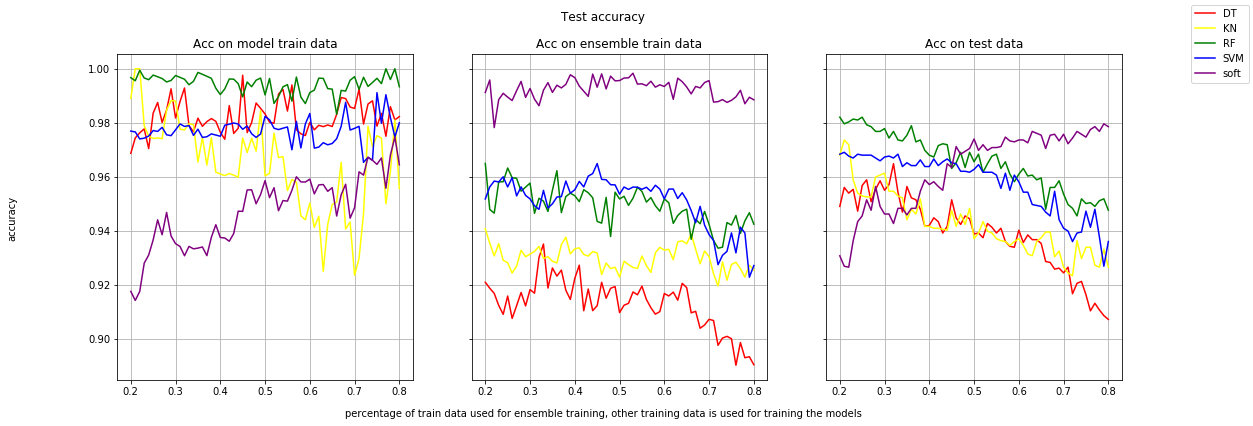

In [9]:
#create plots from the scores in the dataframe

def plot_scores(df_scores):
    #group df_scores per fold
    folds_grouped = df_scores.groupby(['classifier','train2 size']).agg({'train1 acc':['mean','std'],  'train2 acc':['mean','std'], 'test acc':['mean','std']})
    folds_grouped = folds_grouped.reset_index()
    folds_grouped.columns

    #plot initialization
    f, axs = plt.subplots(1,3, sharex='col', sharey='row',figsize=(18, 6))
    colors = ['red', 'yellow','green', 'blue','purple']
    color_inx = 0

    #plot per classifier the mean accuracy against the split
    for clf in folds_grouped[( 'classifier',     '')].unique():
        temp = folds_grouped[folds_grouped['classifier']==clf]
        axs[0].plot(temp['train2 size'], temp[( 'train1 acc', 'mean')], color=colors[color_inx])
        axs[1].plot(temp['train2 size'], temp[( 'train2 acc', 'mean')], color=colors[color_inx])
        axs[2].plot(temp['train2 size'], temp[( 'test acc', 'mean')], label=clf, color=colors[color_inx])
        color_inx = color_inx+1

    #plot grid
    for ax in range(3):
        axs[ax].grid()

    #plot titles
    f.suptitle('Test accuracy')
    axs[0].set_title('Acc on model train data')
    axs[1].set_title('Acc on ensemble train data')
    axs[2].set_title('Acc on test data')
    f.text(0.5, 0.04, 'percentage of train data used for ensemble training, other training data is used for training the models', ha='center')
    f.text(0.04, 0.5, 'accuracy', va='center', rotation='vertical')

    #plot legend
    f.legend()
    f.show()
    return True

plot_scores(df_scores)

In [6]:
t = time.time()

#loading datasets
data = pd.read_csv("datasets_180_408_data.csv")


#data preprocessing

#deleting useless columns
#deleting the "id" column
data.drop("id",axis=1,inplace=True)
#deleting the "Unnamed: 32" column
data.drop("Unnamed: 32",axis=1,inplace=True) 

#counting the diagnosis variable
print(data.diagnosis.value_counts())

#replacing M and B with 1 and 0 respectively
data.diagnosis=data.diagnosis.map({'M':1,'B':0})

#shuffle rows of data to achieve a random split in the train and test set
data.sample(frac=1, random_state=0).reset_index(drop=True)


#initialize parameters for cross validation and train split
nfolds = 5
split_start = 0.2 #tussen 0 en 1
split_end = 0.8 # tussen 0 en 1, groter dan split_start
split_stepsize = 0.01
scores2 = []

for fold in range(nfolds):
    #split data into train and test data
    start_inx = int(len(data)*(fold/nfolds))
    end_inx = int(len(data)*((fold+1)/nfolds))
    train = data[(data.index < start_inx) | (data.index >= end_inx)]
    test = data[(data.index >= start_inx) | (data.index < end_inx)]

    #split the train and test data into independent and responsible variables
    train_X = train.iloc[:, 1:31]
    train_y = train.diagnosis
    test_X = test.iloc[:,1:31]
    test_y = test.diagnosis
        
        
    #train classifiers

    #KNeighborsClassifier
    clf_DT = train_DecisionTree(train_X, train_y)
    clf_RF = train_RandomForest(train_X, train_y)
    clf_SVM = train_SVM(train_X, train_y)
    clf_KN = train_KNeighborsClassifier(train_X, train_y)

    #Ensamble, soft voting classifier
    clf_soft =  VotingClassifier(estimators=[('DT', clf_DT), ('RF', clf_RF), ('SVM', clf_SVM), ('KN', clf_KN)], voting='soft')
    clf_soft.fit(train_X, train_y)

    #calculate score for every classifier
    for clf, label in zip([clf_DT, clf_RF, clf_SVM, clf_KN, clf_soft], 
                          ['DT', 'RF', 'SVM', 'KN', 'soft']):

        #calculate score
        scores_train = clf.score(train_X, train_y)
        scores_test = clf.score(test_X, test_y)

        #add score to list with scores
        score = [fold, label, scores_train, scores_test]
        scores2.append(score)

#turn list with scores into a dataframe
df_scores2 = pd.DataFrame(scores2, columns=['fold', 'classifier', 'train acc', 'test acc'])

#print the training time
print('seconds running:', time.time()-t)

#write dataframe with scores to csv
df_scores2.to_csv('scores_no_split')
df_scores2

B    357
M    212
Name: diagnosis, dtype: int64
seconds running: 2520.0356736183167


,fold,classifier,train acc,test acc
0,0,DT,0.969298,0.952548
1,0,RF,0.997807,0.977153
2,0,SVM,0.978070,0.964851
3,0,KN,1.000000,0.973638
4,0,soft,1.000000,0.980668
5,1,DT,0.997802,0.973638
6,1,RF,0.995604,0.985940
7,1,SVM,0.971429,0.966608
8,1,KN,0.945055,0.942004
9,1,soft,0.997802,0.987698


In [7]:
#create a table containing the scores of the models trained with no split for the train data

#group df_scores per fold
folds_grouped2 = df_scores2.groupby('classifier').agg({'train acc':['mean','std'], 'test acc':['mean','std']})
folds_grouped2

train acc            test acc          
                mean       std      mean       std
classifier                                        
DT          0.985508  0.015877  0.970826  0.012464
KN          0.964396  0.032613  0.957469  0.021788
RF          0.996045  0.002866  0.987346  0.006263
SVM         0.972317  0.003354  0.967663  0.002358
soft        0.997363  0.003611  0.988401  0.005063